__Statistical learning and applications__
<br>_Professor: R. Elie_
<br>_Students: M. Berezov, V. Oliinyk_

## House Price Prediction

### Summary

   Problem description
1. [Data exploration](#data_exploration)

    1.1 Data preprocessing
        ▸ Loading & understanding data structure
        ▸ Removing duplicated rows 
        ▸ Missing values treatment
    1.2 Analysis of numeric variables
        ▸ Analysis of a target variable SalePrice
        ▸ Visualization of numeric features
        ▸ Treating skewed variables
        ▸ Analysis of correlations with target and multicollinearity
    1.3 Analysis of categorical variables
        ▸ Visualization of categorical features
        ▸ Analysis of relation with target 
        ▸ One-hot ecnoding
2. [Feature engineering](#feature_eng) 

3. [Models](#models) 

    3.1 Penalized Linear Regressions 
        ▸ LASSO
        ▸ Ridge
        ▸ Elastic Net
        ▸ Kernel Ridge
    3.2 Boosting models
        ▸ GradientBoostingRegressor: GBoost
        ▸ Boosting regression trees: XGBoost
    3.3 Neural Networks Regression

[Ensemble](#ensemble)   
Conclusion

## 0. Problem Description


In this project we are going to predict the prices of houses based on variables describing (almost) every aspect of residential homes in Ames, Iowa.

The data is provided by __Kaggle__ within the framework of the competition  "House Prices: Advanced Regression Techniques" and can be found via the following link: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

__Goal:__  
  To predict the sales price for each house. For each Id in the test set, we need to predict the value of the SalePrice variable. 

__Metric:__  
  Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. 

$$RMSE_{log} = \sqrt{\frac{1}{n}\sum_{i=1}^n\big(log(y_i) - log(\hat{y}_i) \big)^2}$$

_Remark:_ Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.

In order to reach the goal we take __three__ steps:

1. We perform exhaustive _exploratory_ analysis
2. We create new features from given ones
3. We build models, tune their parameters and train them on the given data

Finally, we build the ensemble of the subset of models and evaluate the performance of the resulting ensemble on the test data on Kaggle platform.

<a id='data_exploration'></a>
## 1. Data Exploration

### 1.1 Data preprocessing  
 #### ▸ Loading & understanding data structure

In this project we will use such popular libraries as numpy, pandas, scipy, sklearn and visulization tools as matplotlib and seaborn.  
  We will store our data in _dataframes_ enjoying their nice properties.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

In [2]:
print('='*70)
print('Loading data into pandas DataFrame')
print('-'*50)
fn_test = '/Users/Maxim/Downloads/test.csv'
fn_train = '/Users/Maxim/Downloads/train.csv'

test = pd.read_csv(fn_test, delimiter=',')
train = pd.read_csv(fn_train, delimiter=',')

print('Data download completed\n')

test_ind = test['Id']
train_ind = train['Id']
print('Concatenating train and test samples (target variable dropped)')
data = pd.concat([test, train.drop('SalePrice',axis = 1)],axis = 0)
data = data.sort_values(by = 'Id')

Loading data into pandas DataFrame
--------------------------------------------------
Data download completed

Concatenating train and test samples (target variable dropped)


We concatenated test and train datasets (SalePrice variable was droped) into the common dataframe __data__.  
In what follows, we will transform our variables, so it is easier to work with this common dataframe to make sure we are going to deal with the same variables when build models.

Let's take a look at our train and test samples.

In [3]:
print("The shape of train sample: " + str(train.shape))
print("The shape of test sample: " + str(test.shape))

The shape of train sample: (1460, 81)
The shape of test sample: (1459, 80)


We have __81__ variables in the train set (including target variable) and, respectively, __80__ variables in the test set.  
  The sets are balanced in terms of size: we have around 1460 instances in both datasets.

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Excluding Id and the target, we see that there are __79__ explanotary variables in our dataset.  
  In what follows, we will examine _numeric_ and _categorical_ svariables eparately.

#### ▸ Removing duplicated rows 

Removing duplicated rows if present is one of the best practices of data analysis.  
Let's do it.

In [6]:
print('='*70)
print('Data cleansing')
print('Removing duplicates')
data[data.Id.isin(train_ind)] = data[data.Id.isin(train_ind)].drop_duplicates()
print('-'*50)
print('Duplicates removal completed')

Data cleansing
Removing duplicates
--------------------------------------------------
Duplicates removal completed


#### ▸ Missing values treatment

Let us first see which variables from the dataset suffer from missings.
We visualize the results

In [7]:
print('Missings analysis')
total_na = data.isnull().sum().sort_values(ascending = False)
percent_na = (data.isnull().sum()/data.isnull().count()).sort_values(ascending = False)
missing = pd.concat([total_na, percent_na], axis = 1, keys = ['Total', 'Percent'])
missing.head(40)

Missings analysis


,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageCond,159,0.054471
GarageQual,159,0.054471
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471


In [8]:
missing_ind = missing['Percent']>0
print('There are '+str(sum(missing_ind))+ ' variables with at least 1 missing value')

There are 34 variables with at least 1 missing value


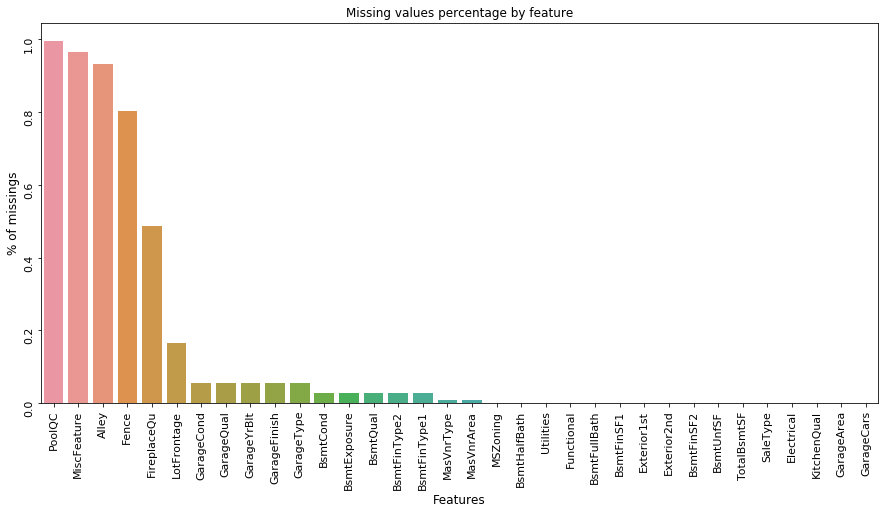

In [9]:
f, ax = plt.subplots(figsize=(15, 7))
plt.xticks(rotation='90',fontsize=11)
plt.yticks(rotation='90',fontsize=11)
sns.barplot(x=missing.index[missing_ind], y=missing.Percent[missing_ind])
plt.xlabel('Features', fontsize=12)
plt.ylabel('% of missings', fontsize=12)
plt.title('Missing values percentage by feature', fontsize=12)

As we see here, __PoolQC, MiscFeature, Alley__ and __Fence__ are the variables that have more than 50% of missing values.
For instance, for a pool quality variable, this is quite natural, since the vas majority of houses don't posses the swimming pool at all. The other variables among mentioned above are similar in the sense that NAs correpond to the absence of a particular facility.

Hence, we will replace NAs with 'None' in cases when the missing stands for the absence of a facility and a variable is categorical, and with 0 if it is numeric.
For the cases when missing is simply an omitted value, we will replace it with either 0 or median according to the type of variable.

In [10]:
for column in ('PoolQC','Fence','Alley','MiscFeature','GarageType', 
               'GarageFinish', 'GarageQual', 'GarageCond', 'FireplaceQu', 
               "MasVnrType", 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
               'BsmtFinType1', 'BsmtFinType2','MSSubClass'):
    data[column] = data[column].fillna('None')
    
for column in('MasVnrArea','GarageYrBlt','GarageArea', 'GarageCars',
              'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 
              'BsmtFullBath', 'BsmtHalfBath'):
    data[column] = data[column].fillna(0)

for column in('Utilities','MSZoning','Exterior1st', 'Exterior2nd', 
              'KitchenQual','Electrical', 'SaleType'):
    data[column] = data[column].fillna(data[column].mode()[0])
               
data["LotFrontage"] =  data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
               
data["Functional"] = data["Functional"].fillna("Typ")

In [11]:
print('Sanity check after filling NAs')
total_na = data.isnull().sum().sort_values(ascending = False)
percent_na = (data.isnull().sum()/data.isnull().count()).sort_values(ascending = False)
missing = pd.concat([total_na, percent_na], axis = 1, keys = ['Total', 'Percent'])
missing.head(40)

Sanity check after filling NAs


,Total,Percent
SaleCondition,0,0.0
SaleType,0,0.0
RoofStyle,0,0.0
RoofMatl,0,0.0
Exterior1st,0,0.0
Exterior2nd,0,0.0
MasVnrType,0,0.0
MasVnrArea,0,0.0
ExterQual,0,0.0
ExterCond,0,0.0


Now, when data is preprocessed, we are ready to explore numeric and categorical features.

### 1.2 Analysis of numeric variables
#### ▸ Analysis of a target variable SalePrice

Let's begin with the target variable, 'SalePrice', the property's sale price in dollars

In [12]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Let us take a closer look at the most important moment of the target's distribution and draw its histogram.

Mean = 180921.19589041095
Dev = 79442.50288288663
Skewness = 1.8828757597682129


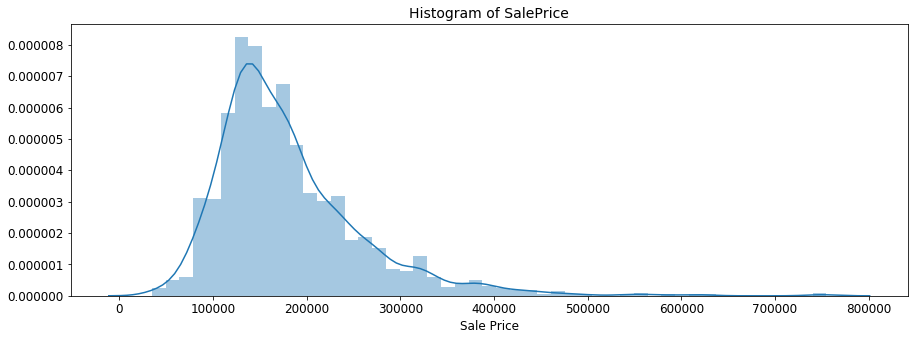

In [13]:
y = train['SalePrice']

print('Mean = '+ str(y.mean()))
print("Dev = "+ str(np.sqrt(y.var())))
print('Skewness = ' + str(y.skew()))

plt.figure(figsize =(15, 5))
sns.distplot(y)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.xlabel('Sale Price',fontsize=12)
plt.title('Histogram of SalePrice', fontsize=14)

As we can see, our target variable is highly skewed. Both skeweness value (>1.8) and the histogram show this.

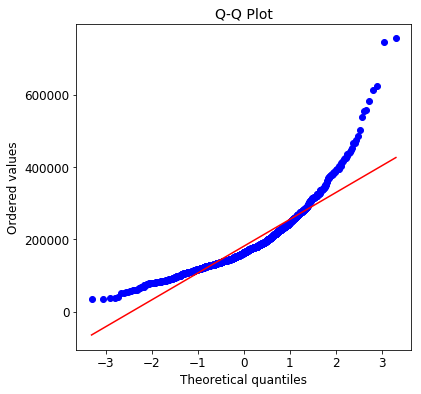

In [14]:
fig = plt.gcf()
fig.set_size_inches(6, 6)
res = stats.probplot(y, plot=plt)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.xlabel('Theoretical quantiles', fontsize=12)
plt.ylabel('Ordered values', fontsize=12)
plt.title('Q-Q Plot', fontsize=14)
plt.show()

Сommon use of Q–Q plots is to compare the empirical distribution with a theoretical one, such as the standard normal distribution: one orders the data , then plots them against certain quantiles of the theoretical distribution. 

As we can see, our data does not fit a straight line of normal distribition

 It is known that dealing with distributions close to normal favours more efficient data processing (e.g., linear models show the best performance for normal-ditributed data).  
 One of common practices in data analysis is to reshape asymmetric distributions. 
  The simplest way to reshape highly skewed distribution is to apply log-transform.  
  Let's do it.

In [15]:
train['SalePrice'] = np.log1p(train['SalePrice'])

Mean = 12.024057394918371
Dev = 0.3994492733225068
Skewness = 0.12134661989685329


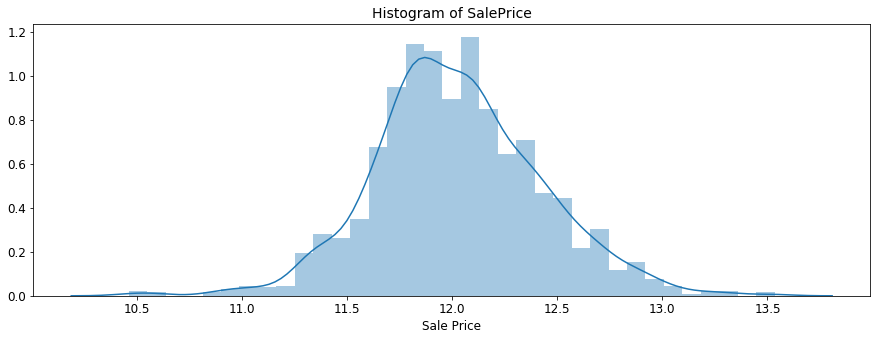

In [16]:
y = train['SalePrice']
plt.figure(figsize =(15, 5))
sns.distplot(y)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.xlabel('Sale Price',fontsize=12)
plt.title('Histogram of SalePrice', fontsize=14)

print('Mean = '+ str(y.mean()))
print("Dev = "+ str(np.sqrt(y.var())))
print('Skewness = ' + str(y.skew()))

As we can see, skewness after log-trasformation significantly decreased and the shape of distribution bell is much more symmetric.

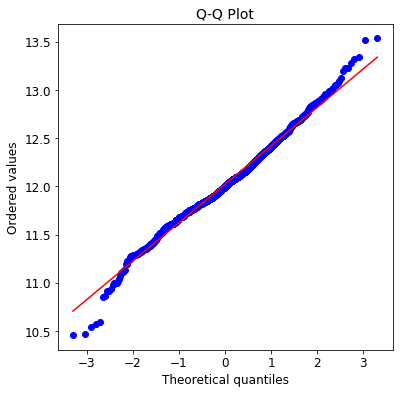

In [17]:
fig = plt.gcf()
fig.set_size_inches(6, 6)
res = stats.probplot(y, plot=plt)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.xlabel('Theoretical quantiles', fontsize=12)
plt.ylabel('Ordered values', fontsize=12)
plt.title('Q-Q Plot', fontsize=14)
plt.show()

Finally, the Q-Q plot shows that target variable is now much closer to the normal distribution.

#### ▸  Visualization of numeric features  

In [18]:
numeric_vars = data.select_dtypes(exclude=['object']).columns.values
numeric_vars = np.delete(numeric_vars, np.where(numeric_vars=='Id'))
print('There are '+ str(len(numeric_vars)) +' numeric features:')
numeric_vars

There are 36 numeric features:


array(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'], dtype=object)

  The numeric features can be brodaly categorized into 4 classes.  
  We give the brief description of these variables  

1. Time-related features  
  __YearBuilt__: Original construction date  
  __YearRemodAdd__: Remodel date  
  __GarageYrBlt__: Year garage was built  
  __MoSold__: Month Sold  
  __YrSold__: Year Sold  
  
2. Area-related features  
  __LotFrontage__: Linear feet of street connected to property  
  __LotArea__: Lot size in square feet  
  __MasVnrArea__: Masonry veneer area in square feet  
  __BsmtFinSF1__: Type 1 finished square feet  
  __BsmtFinSF2__: Type 2 finished square feet  
  __BsmtUnfSF__: Unfinished square feet of basement area  
  __TotalBsmtSF__: Total square feet of basement area  
  __1stFlrSF__: First Floor square feet  
  __2ndFlrSF__: Second floor square feet  
  __LowQualFinSF__: Low quality finished square feet (all floors)  
  __GrLivArea__: Above grade (ground) living area square feet  
  __GarageArea__: Size of garage in square feet  
  __WoodDeckSF__: Wood deck area in square feet  
  __OpenPorchSF__: Open porch area in square feet  
  __EnclosedPorch__: Enclosed porch area in square feet  
  __3SsnPorch__: Three season porch area in square feet  
  __ScreenPorch__: Screen porch area in square feet  
  __PoolArea__: Pool area in square feet  
  
3. Quantity-related features  
  __BsmtFullBath__: Basement full bathrooms  
  __BsmtHalfBath__: Basement half bathrooms  
  __FullBath__: Full bathrooms above grade  
  __HalfBath__: Half baths above grade  
  __BedroomAbvGr__: Bedrooms above grade  
  __KitchenAbvGr__: Kitchen above grade  
  __TotRmsAbvGrd__: Total rooms above grade (does not include bathrooms)  
  __Fireplaces__: Number of fireplaces  
  __GarageCars__: Size of garage in car capacity  
  
4. Quality-related features  
  __MSSubClass__:  The building class   
  __OverallQual__: Overall material and finish quality  
  __OverallCond__: Overall condition rating  
  __MiscVal__: U.S.dollar Value of miscellaneous feature  

We notice that while some of these variables are _purely_ numeric (like area-related and quantity-related features), the others should be treated more thoroughly. E.g., it might be a good idea to convert time-related variables into quantites like _house age_, etc. Moreover, notice that we should turn some quality-related freatures into _categorical_ features if these categories are not ordered.

This gives us some ideas for a future feature engineering.

In [19]:
# Factorizing intrinsically categorical variables
data['MSSubClass'] = data['MSSubClass'].apply(str)

# Updating numeric_vars 
numeric_vars = np.delete(numeric_vars, np.where(numeric_vars=='MSSubClass'))

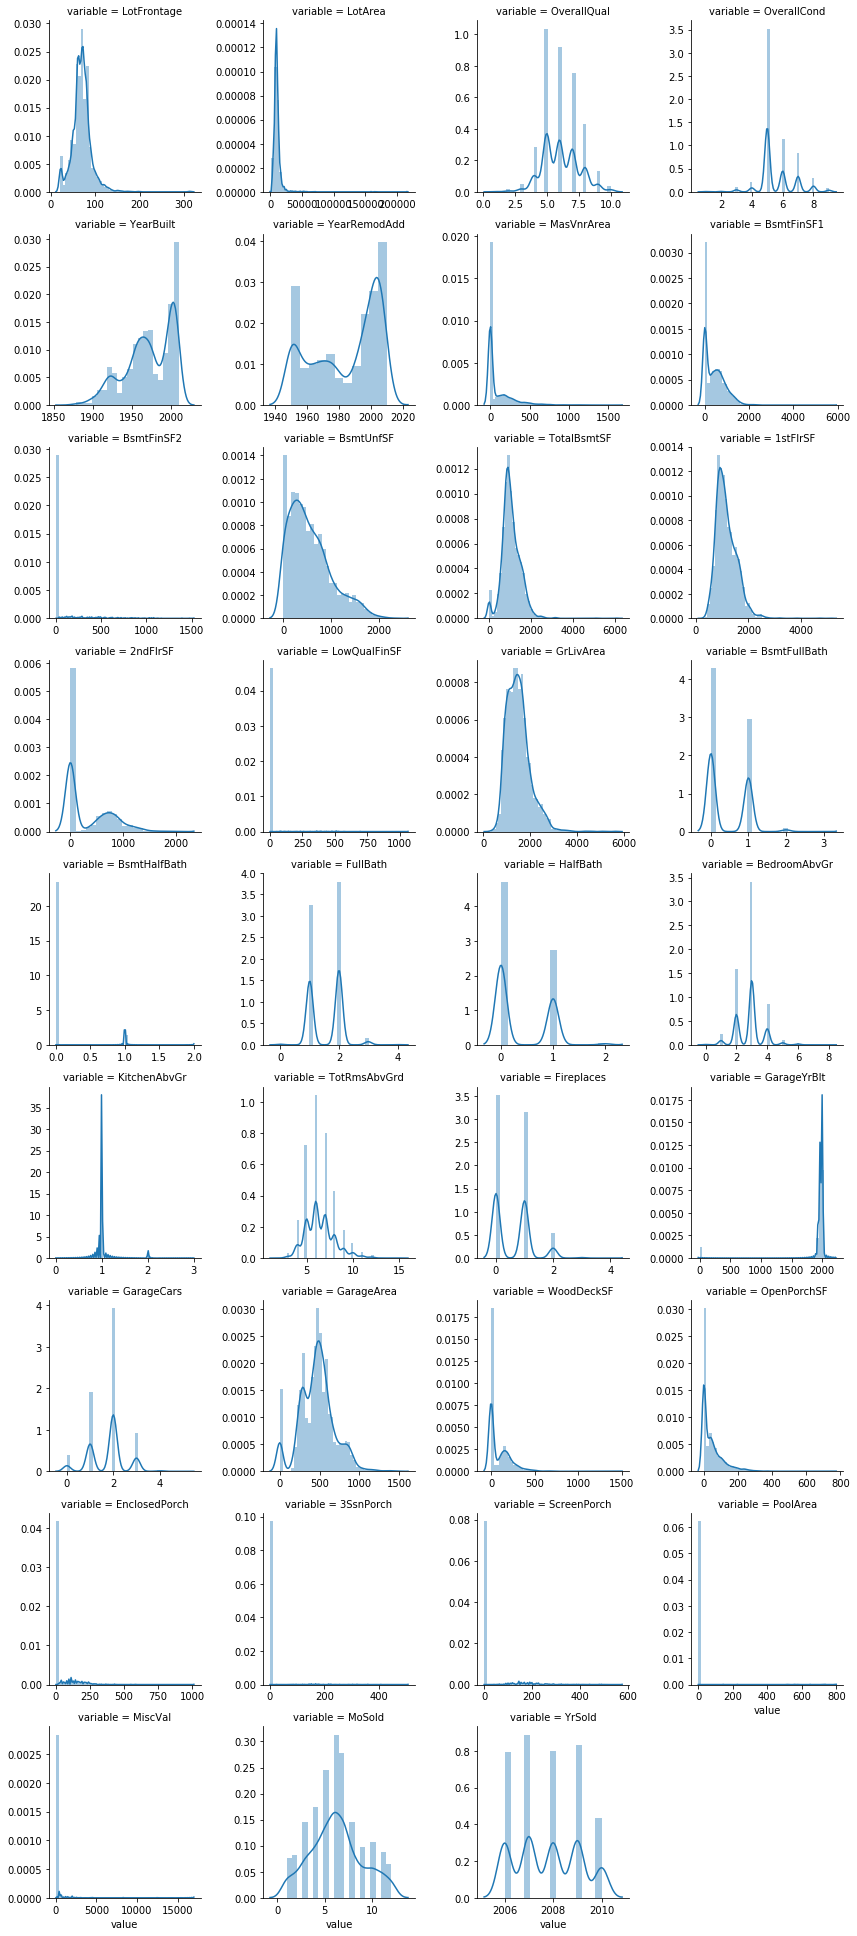

In [20]:
f = pd.melt(data, value_vars=numeric_vars)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

#### ▸  Treating skewed variables  
From histograms we see that some variables exhibit high assymetry.  
Let's consider that threshhold of 0.75 for skewness and print out the valriables that depass this threshold.

In [21]:
import scipy.stats.stats as st
skewed = data[numeric_vars].apply(lambda x: st.skew(x.dropna())).sort_values(ascending=False)
skewed = skewed[abs(skewed) > 0.75]

The list of skewed features

In [22]:
skewed

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
MasVnrArea        2.613592
OpenPorchSF       2.535114
WoodDeckSF        1.842433
LotFrontage       1.505704
1stFlrSF          1.469604
BsmtFinSF1        1.425230
GrLivArea         1.269358
TotalBsmtSF       1.156894
BsmtUnfSF         0.919339
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
GarageYrBlt      -3.906205
dtype: float64

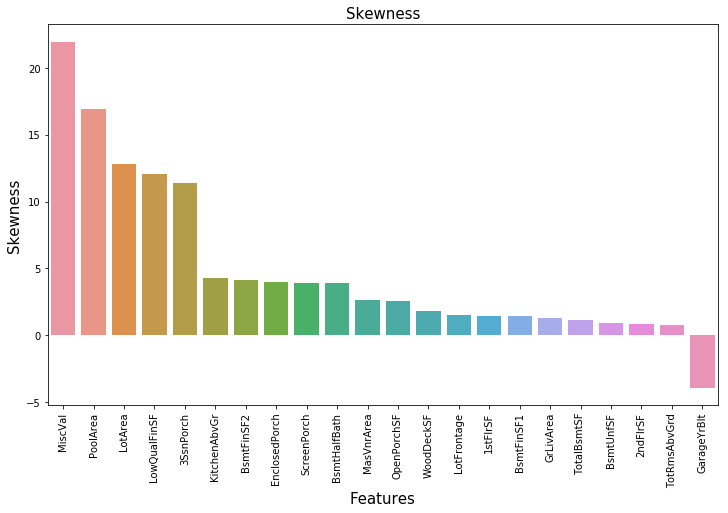

In [23]:
f, ax = plt.subplots(figsize=(12, 7))
plt.xticks(rotation='90')
sns.barplot(x=skewed.index, y=skewed)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Skewness', fontsize=15)
plt.title('Skewness', fontsize=15)

Again, as for the case of target SalePrice, we need to apply log-transform to the skewed variables.

In [24]:
data[skewed.index] = np.log1p(data[skewed.index])
skewed = data[numeric_vars].apply(lambda x: st.skew(x.dropna())).sort_values(ascending=False)
skewed= skewed[abs(skewed) > 0]

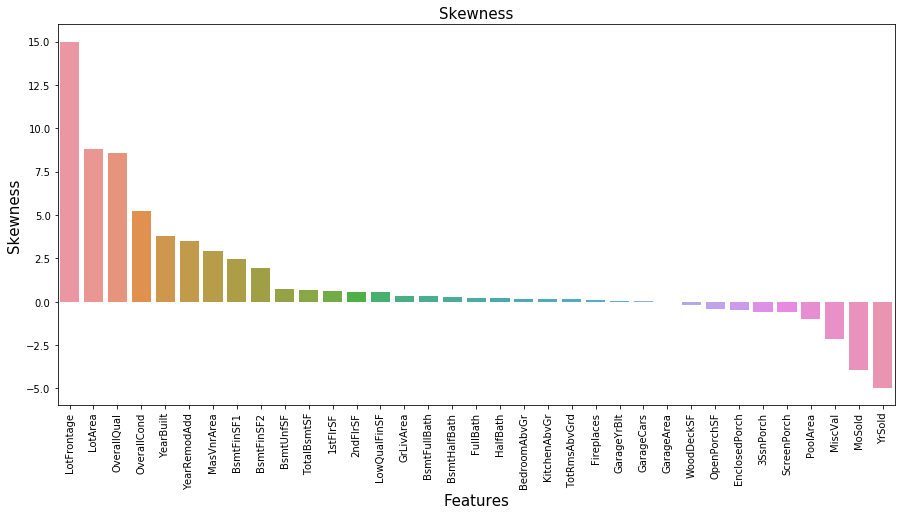

In [25]:
f, ax = plt.subplots(figsize=(15, 7))
plt.xticks(rotation='90')
sns.barplot(x=numeric_vars, y=skewed)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Skewness', fontsize=15)
plt.title('Skewness', fontsize=15)

As a result, we managed to reach significant skewness decrease for some features.

#### ▸  Analysis of correlations with target

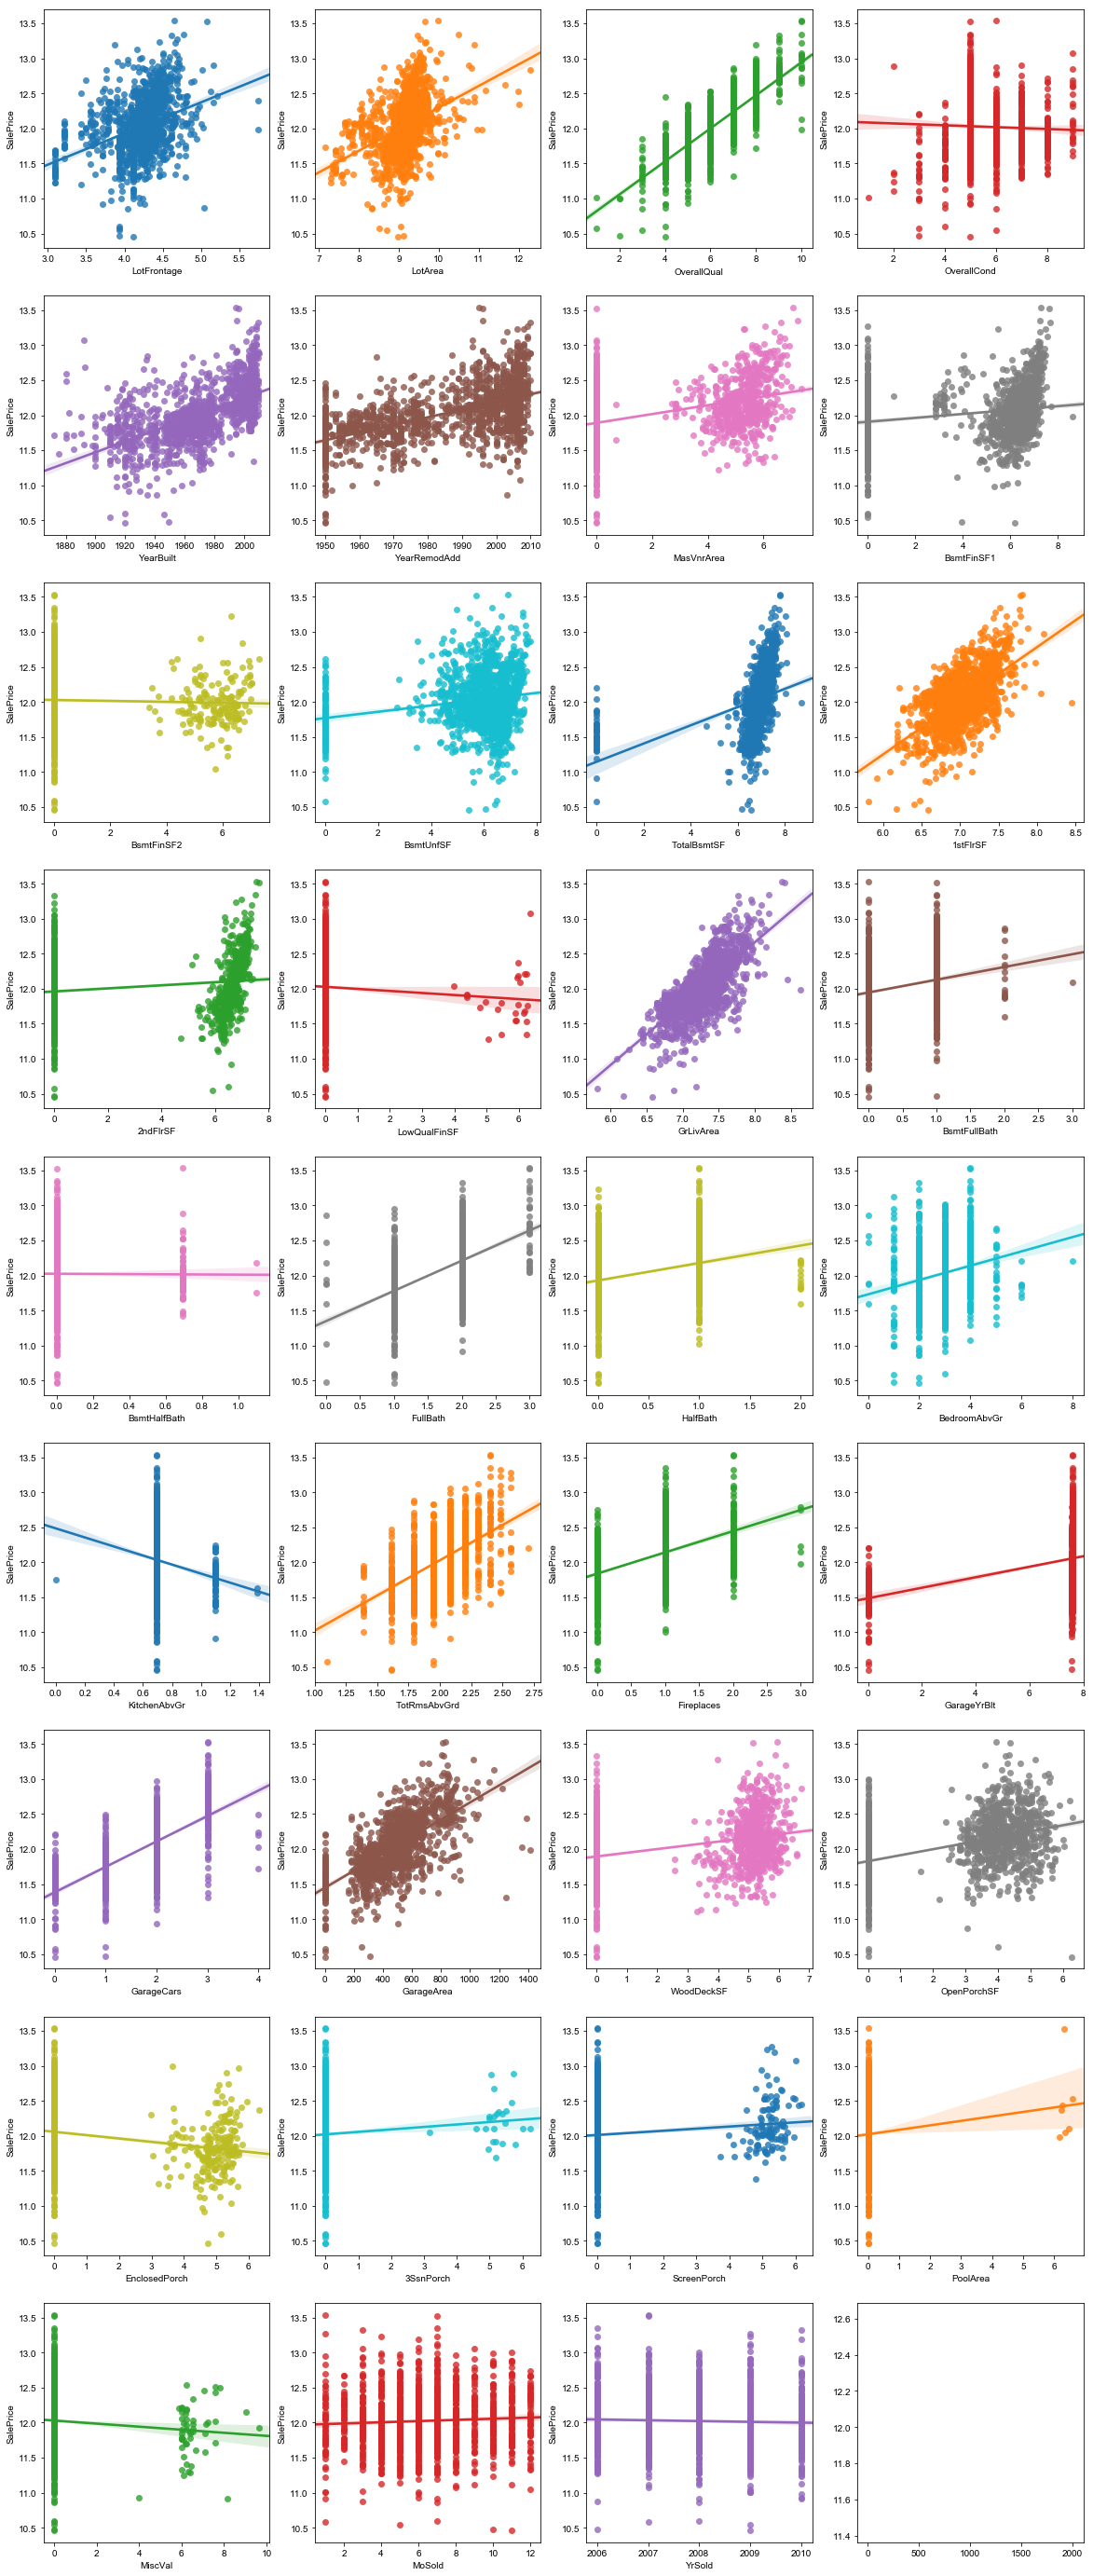

In [26]:
fig, ax = plt.subplots(9, 4, figsize = (20, 50))
for i, numeric_var in enumerate(numeric_vars):
    sns.set(font_scale = 1)
    sns.regplot(x = numeric_var, y = y, data = data[data.Id.isin(train_ind)], ax = ax[i//4, i%4])

From scatter plots we can see that there is a strong relation between our target and the variables __OverallQual,GrLivArea,  1stFlrSF, TotRmsAbvGrd, GarageCars, FullBath.__  

We also see that for some variables there is a very strong and steep relation with target when 0 value is excluded (e.g., TotalBsmtSF, 2ndFltSF, GarageArea, etc.)

Let us make our analysis more formal and compute the pairwise correlations of numeric variables.  
Not only we will se which variables exhibit the strongest linear relation with the target, but also it will be the first step of multicollinearity analysis.

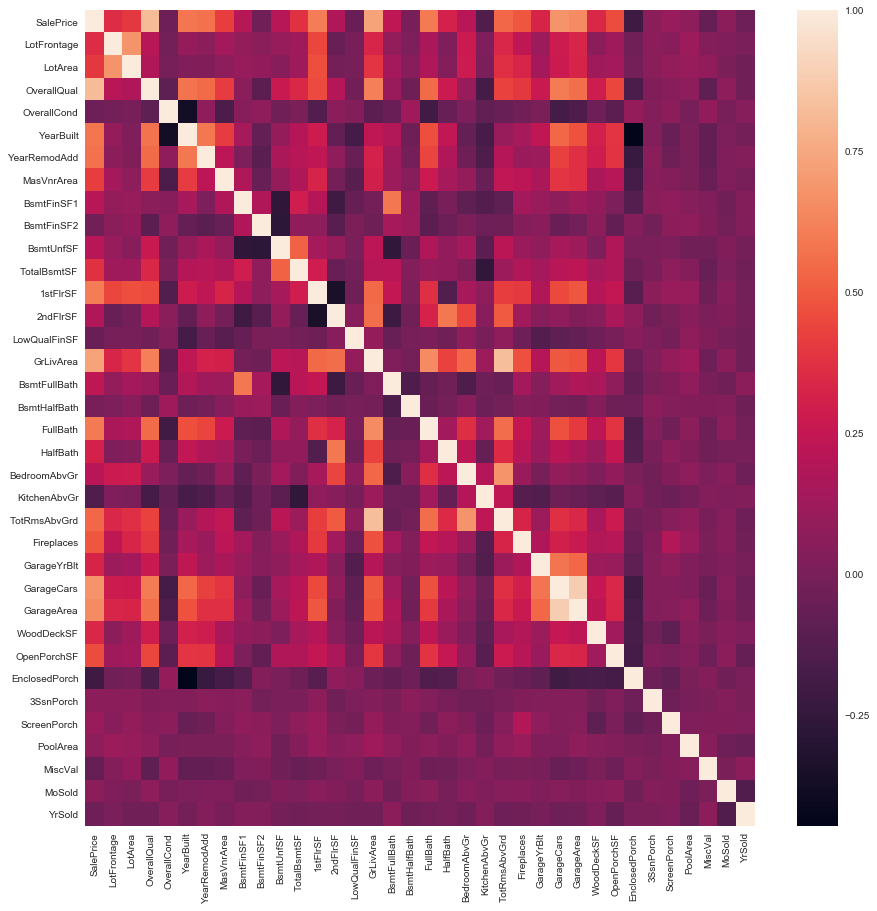

In [27]:
df = pd.concat([train['SalePrice'], data[data.Id.isin(train_ind)][numeric_vars]], axis = 1)
corrmatrix = df.corr()
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corrmatrix);
plt.show()

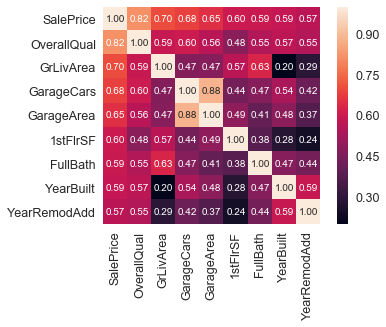

In [28]:
k = 9 # number of variables for heatmap
cols = corrmatrix.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, 
                 square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [29]:
print('The variables that are the most correlated with target are:')
print(corrmatrix.nlargest(k, 'SalePrice')['SalePrice'][1:])

print('')
print(corrmatrix.nsmallest(k//2, 'SalePrice')['SalePrice'])

The variables that are the most correlated with target are:
OverallQual     0.817185
GrLivArea       0.730254
GarageCars      0.680625
GarageArea      0.650888
1stFlrSF        0.608955
FullBath        0.594771
YearBuilt       0.586570
YearRemodAdd    0.565608
Name: SalePrice, dtype: float64

EnclosedPorch   -0.207263
KitchenAbvGr    -0.144278
MiscVal         -0.067054
LowQualFinSF    -0.054513
Name: SalePrice, dtype: float64


Indeed, as stated above, the variables that have the strongest positive correlation are:
__OverallQual, GrLivArea, GarageCars, 1stFlrSF, YearBuilt, FullBath, YearRemodAdd, TotRmsAbvGrd__.

We see that there is no variables that are strongle negatively correlated with target.

Finally, notice that __GarageArea__ and __GarageCars__ are highly correlated as well as __GrLivArea__ and __TotRmsAbvGrd__. During the feature engineering process we should treat this cases thoroughly and delete the variable that is less correlated with the target from these pairs.

### 1.3 Analysis of categorical variables

#### ▸ Visualization of categorical features

Now, let us switch to the analysis of categorical features.

In [30]:
categorical_vars = data.select_dtypes(include=['object']).columns.values
print('There are '+ str(len(categorical_vars)) + ' categorical features:')
categorical_vars

There are 44 categorical features:


array(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'], dtype=object)

  The categorical features can be brodaly categorized into 2 classes.  
  We give the brief description of these variables  

1. Features with not-ordered categories:  
  __MSZoning__: The general zoning classification  
  __Street__: Type of road access  
  __Alley__: Type of alley access  
  __LotShape__: General shape of property  
  __LandContour__: Flatness of the property  
  __LotConfig__: Lot configuration  
  __LandSlope__: Slope of property  
  __Neighborhood__: Physical locations within Ames city limits  
  __Condition1__: Proximity to main road or railroad  
  __Condition2__: Proximity to main road or railroad (if a second is present)  
  __BldgType__: Type of dwelling  
  __HouseStyle__: Style of dwelling  
  __RoofStyle__: Type of roof  
  __RoofMatl__: Roof material  
  __Exterior1st__: Exterior covering on house  
  __Exterior2nd__: Exterior covering on house (if more than one material)  
  __MasVnrType__: Masonry veneer type  
  __Foundation:__ Type of foundation  
  __BsmtExposure:__ Walkout or garden level basement walls  
  __GarageType:__ Garage location  
  __Heating:__ Type of heating  
  __PavedDrive:__ Paved driveway  
  __SaleType:__ Type of sale  
  __SaleCondition:__ Condition of sale  
  __MiscFeature:__ Miscellaneous feature not covered in other categories  
  
2. Features with ordered categories (aka quality-related features):  
  __ExterQual__: Exterior material quality  
  __ExterCond:__ Present condition of the material on the exterior  
  __BsmtQual:__ Height of the basement  
  __BsmtCond:__ General condition of the basement 
  __BsmtExposure:__ Walkout or garden level basement walls
  __BsmtFinType1:__ Quality of basement finished area
  __BsmtFinType2:__ Quality of second finished area (if present)
  __LandSlope__: Slope of property  
  __Utilities__: Type of utilities available 
  __HeatingQC:__ Heating quality and condition  
  __CentralAir:__ Central air conditioning  
  __Electrical:__ Electrical system  
  __KitchenQual:__ Kitchen quality  
  __Functional:__ Home functionality rating  
  __FireplaceQu:__ Fireplace quality  
  __GarageFinish:__ Interior finish of the garage
  __GarageQual:__ Garage quality  
  __GarageCond:__ Garage condition  
  __PoolQC:__ Pool quality  
  __Fence:__ Fence quality  
  
Here we should notice that variables with not-ordered categories should be factorized (one-hot encoded) further.

In [31]:
categorical_vars_less10 = categorical_vars[data[categorical_vars].nunique() < 10]
categorical_vars_more10 = categorical_vars[data[categorical_vars].nunique() >= 10]

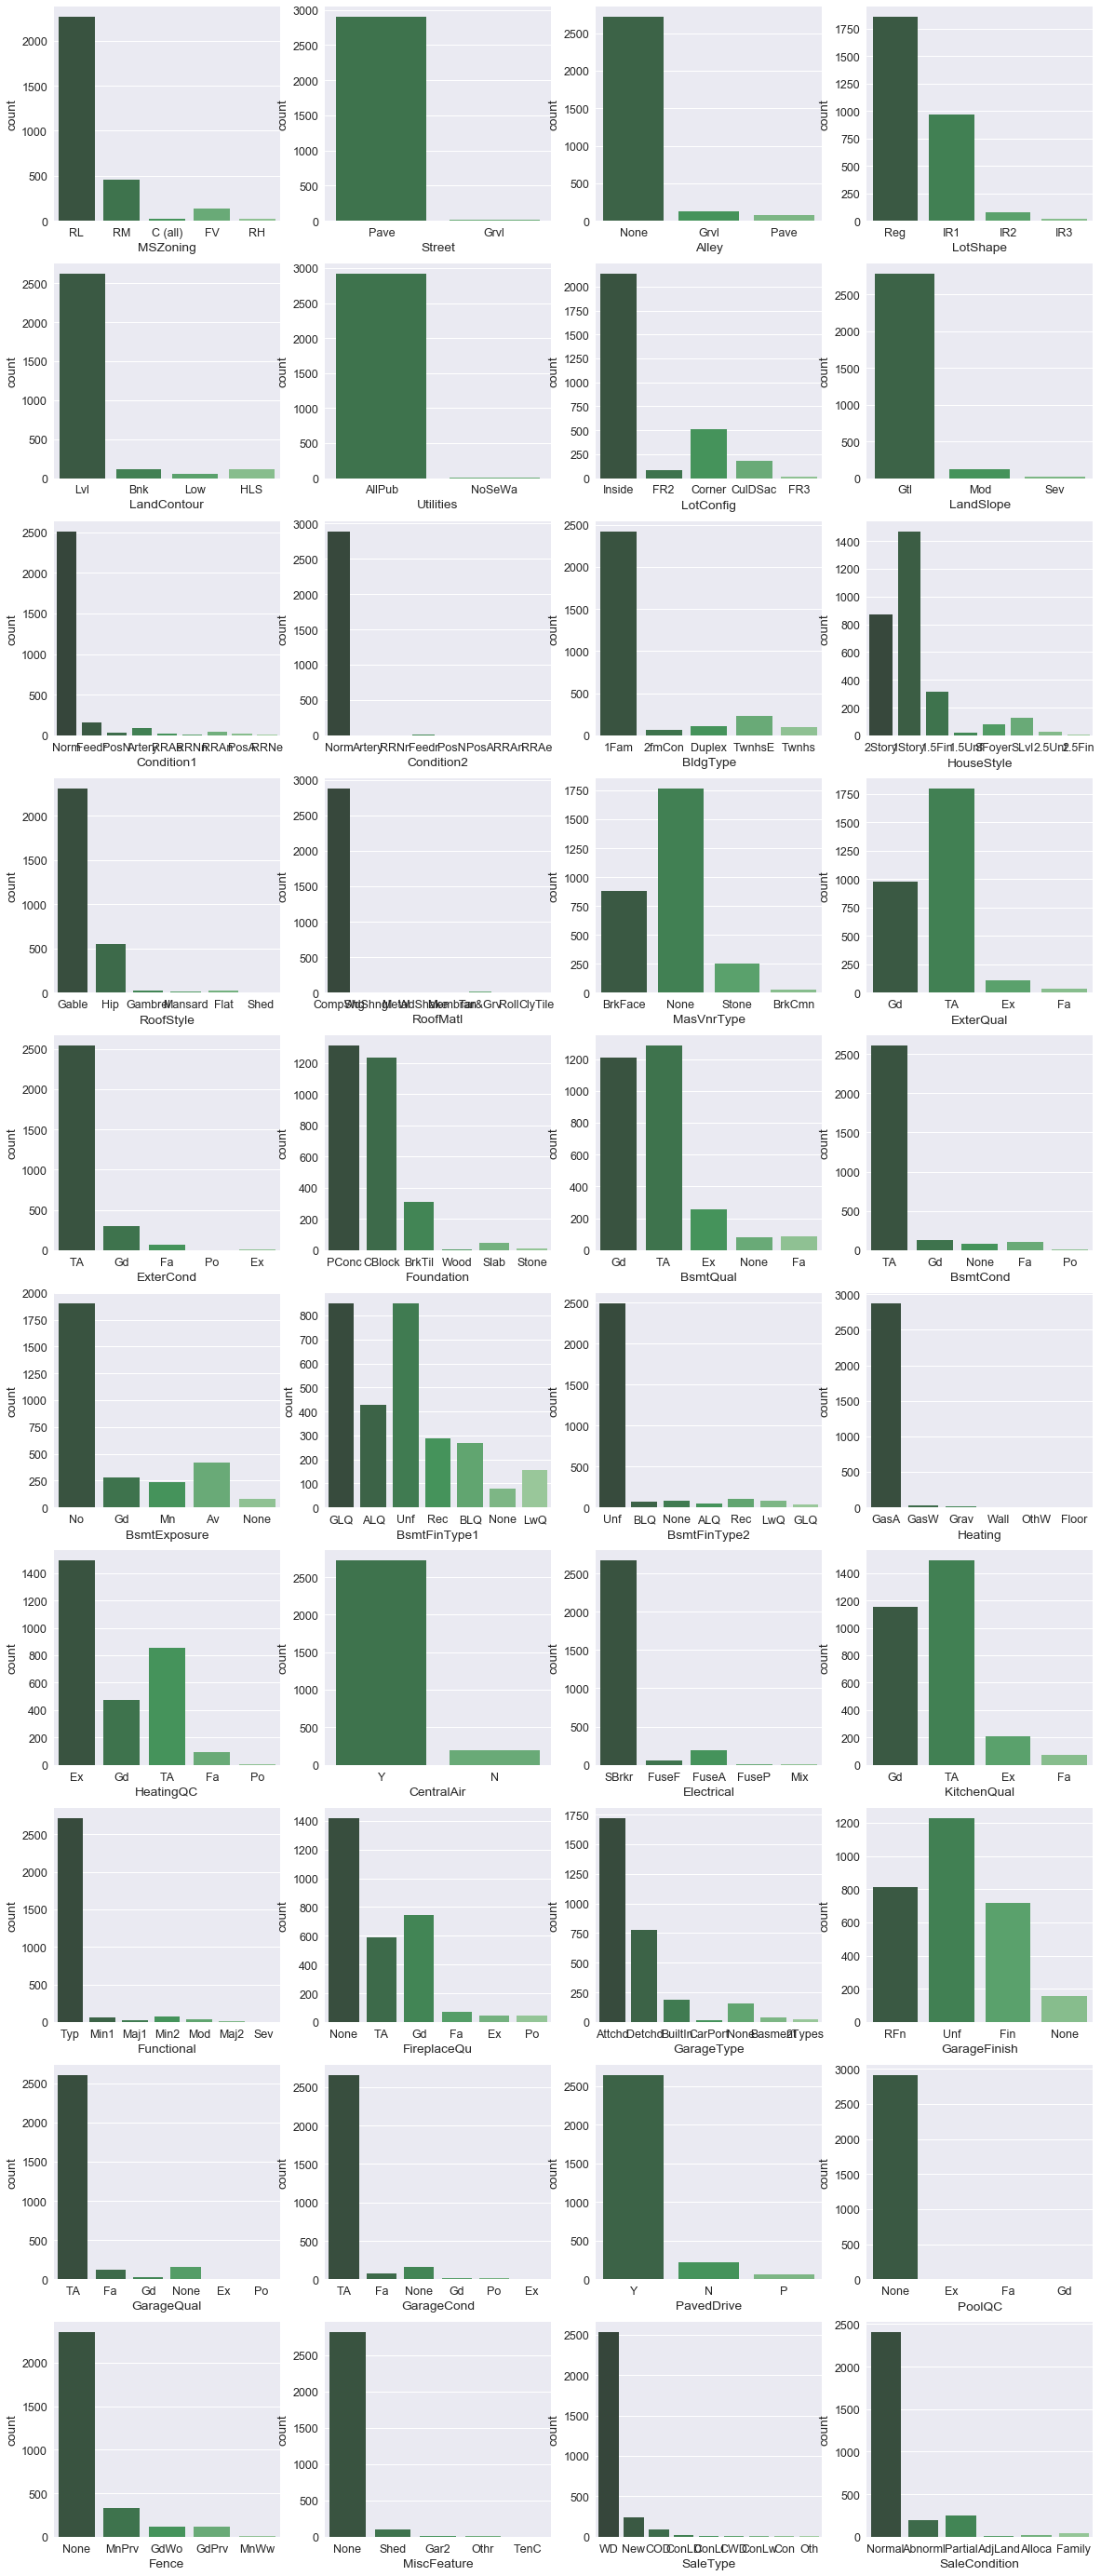

In [32]:
fig, ax = plt.subplots(10, 4, figsize = (20, 50))
for i, categorical_var in enumerate(categorical_vars_less10):
    sns.countplot(x = categorical_var, data = data, palette = "Greens_d", ax = ax[i//4, i%4])

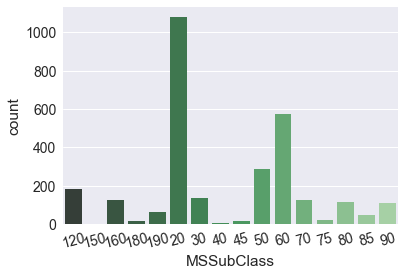

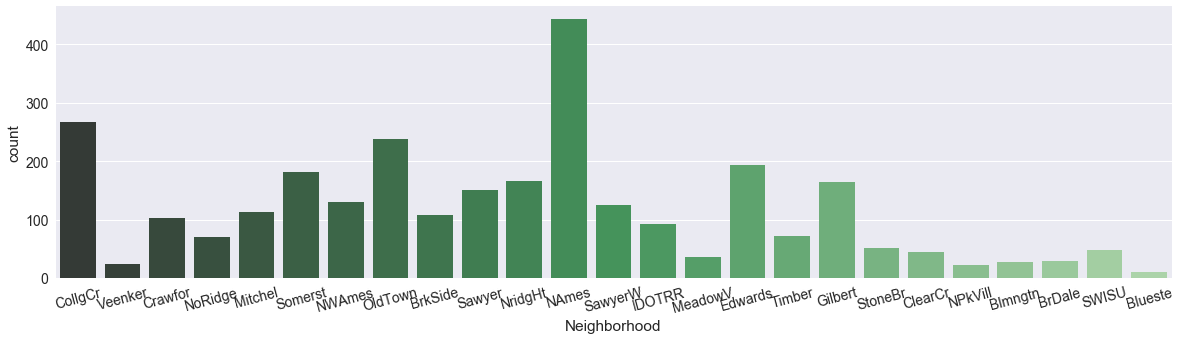

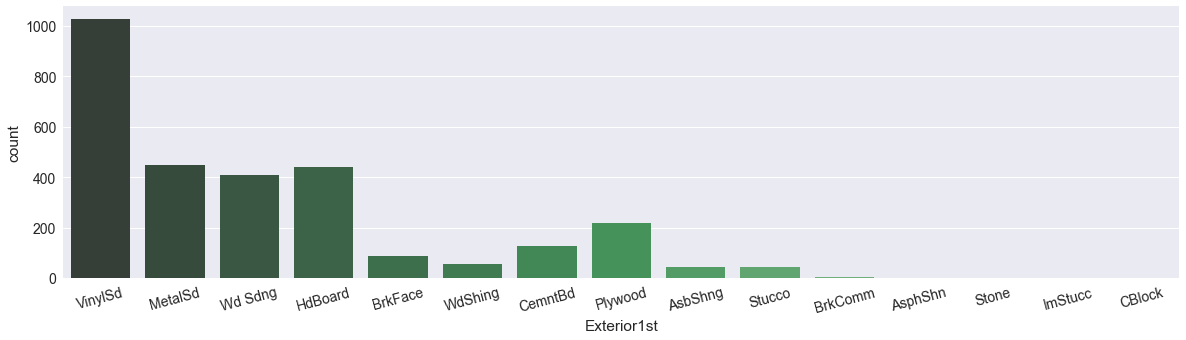

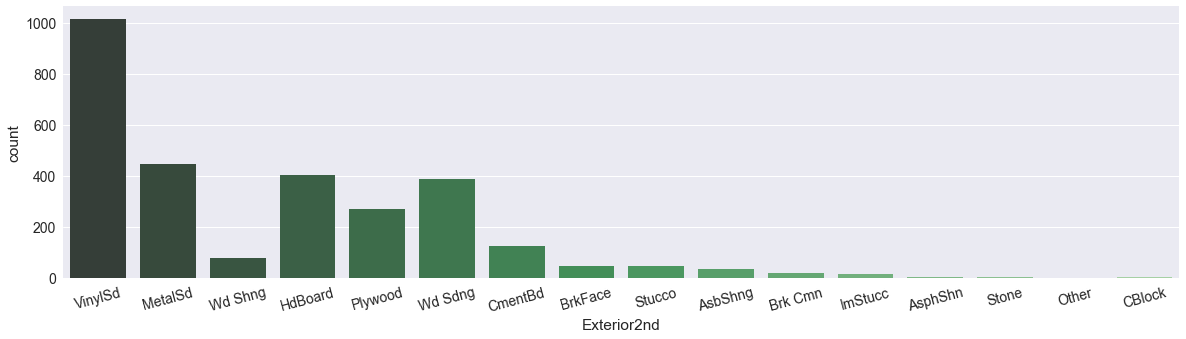

In [33]:
for i, categorical_var in enumerate(categorical_vars_more10):
    plt.figure()
    sns.set(rc={'figure.figsize':(20,5)})
    sns.set(font_scale = 1.4)
    sns.countplot(x = categorical_var, data = data, palette = "Greens_d")
    xt = plt.xticks(rotation=15)
    plt.show()

From all these histograms we see that the large number of variables doesn't have high variance.
E.g., variables as __Street, Condition1, Condition2, RoofMatl, PoolQC__ for almost all objects take the same value. 

Even though there is a pratice in data analysis to drop variables with low variance, we will not do this. Consider, for instance, the variable PoolQC. There is very few houses with a pool, but if the house does have a pool, we might know how much this would cost and this would help us to predict the price much more accurately.  
Hence, we need to investigate the relation between these variables and the target to decide whether or not they are informative.

#### ▸ Analysis of relation with target 

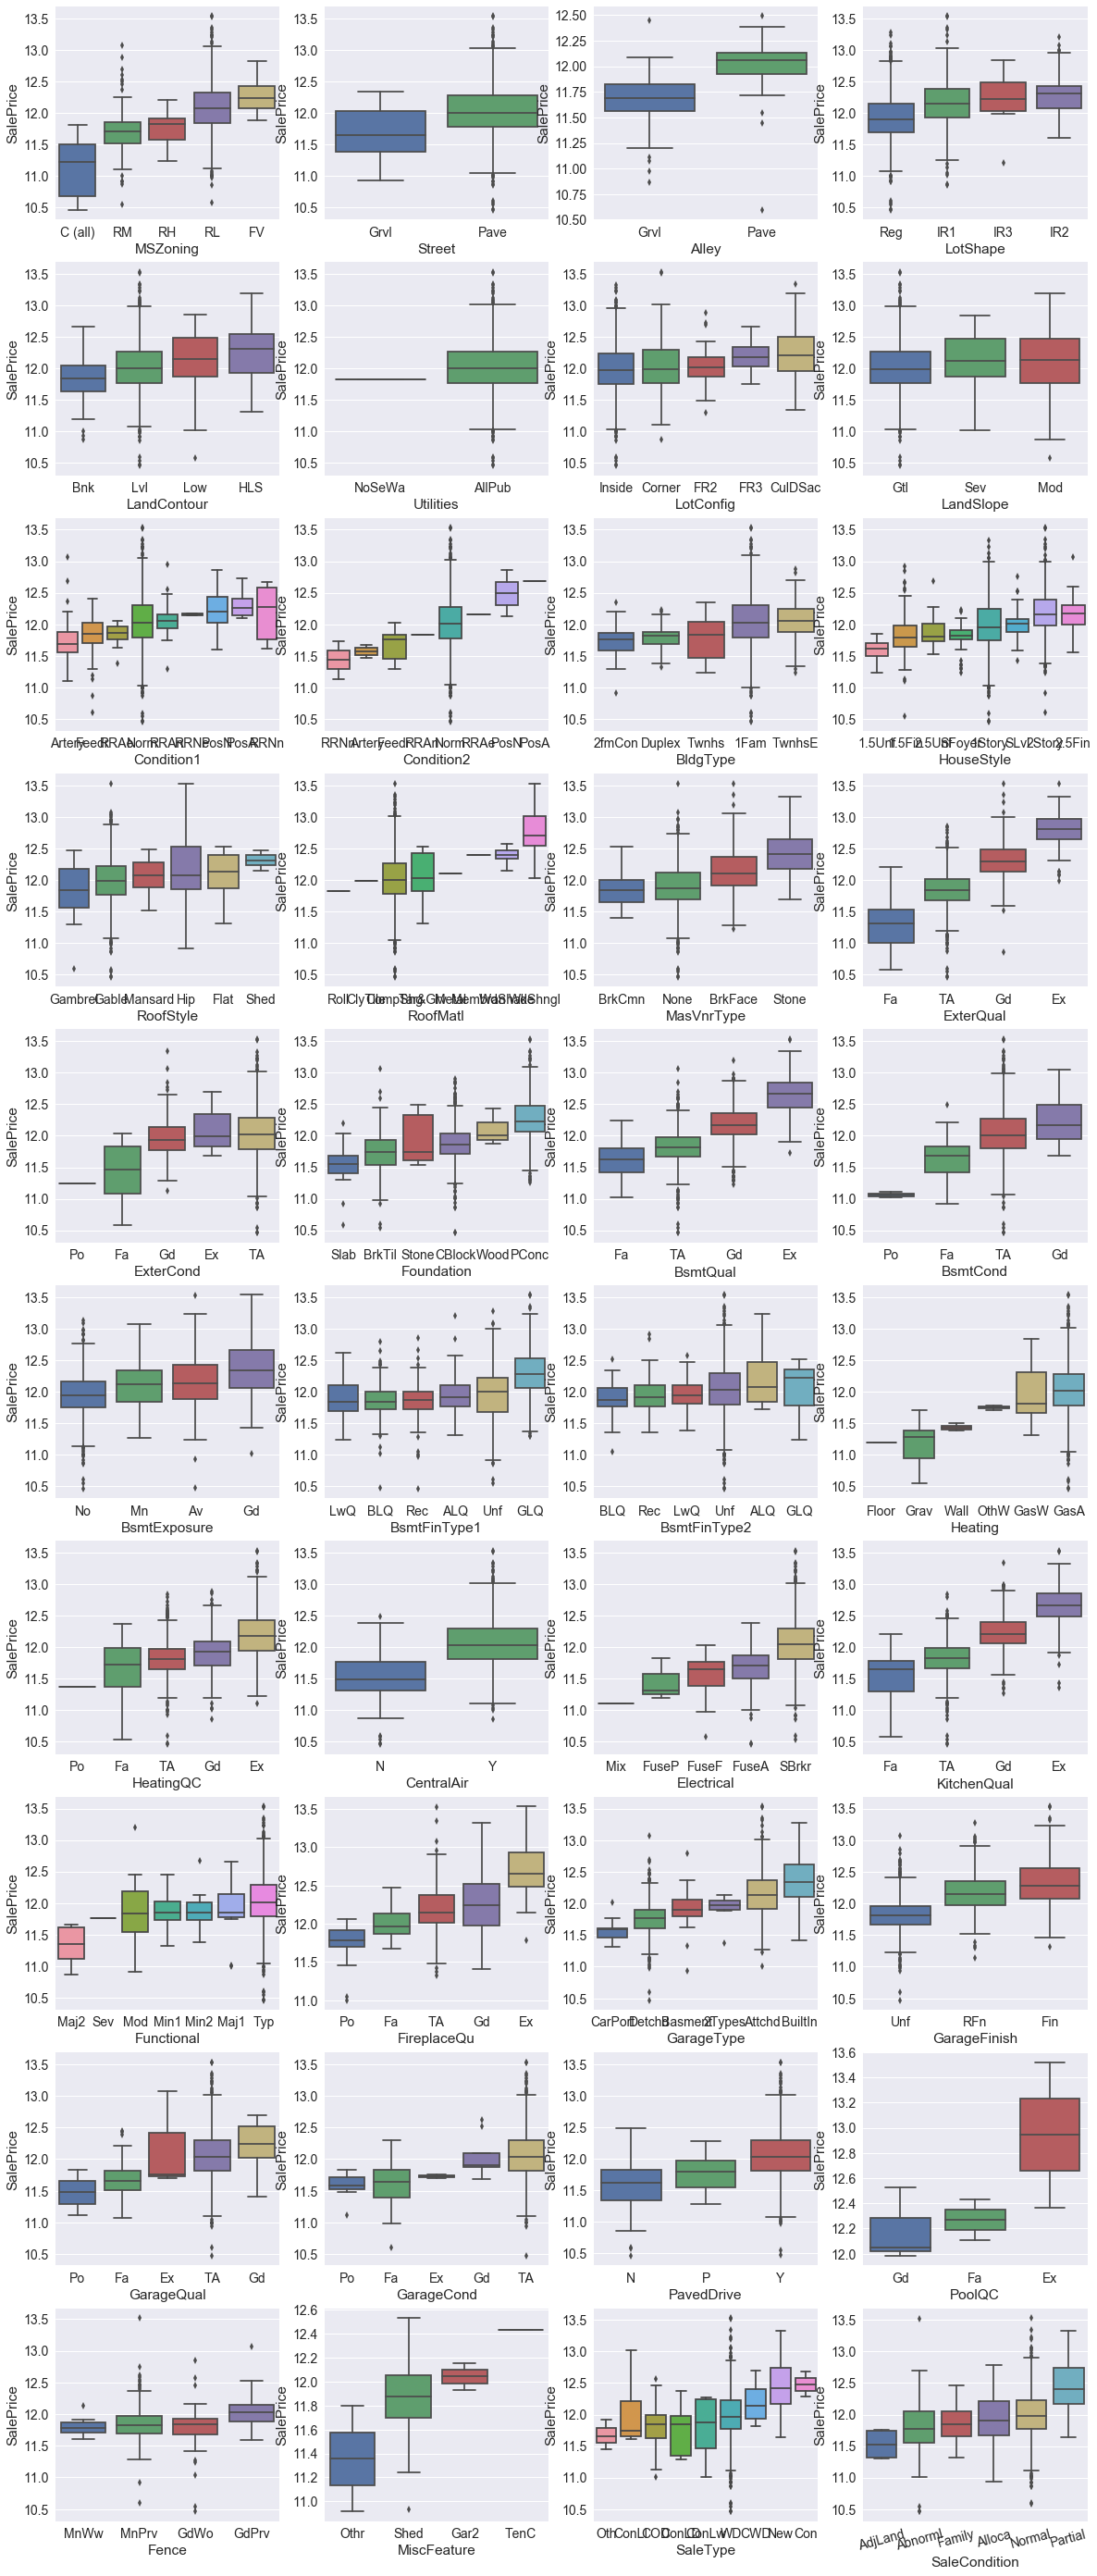

In [34]:
fig, ax = plt.subplots(10, 4, figsize = (20, 50))
for i, categorical_var in enumerate(categorical_vars_less10):
    sns.set(font_scale = 1)
    meds = pd.DataFrame(train.groupby(categorical_var).SalePrice.median())
    ordering = meds.sort_values(by = 'SalePrice').index
    sns.boxplot(x = categorical_var, y = y,  
                data = train, 
                order = ordering, ax = ax[i//4, i%4])
    plt.xticks(rotation=15)

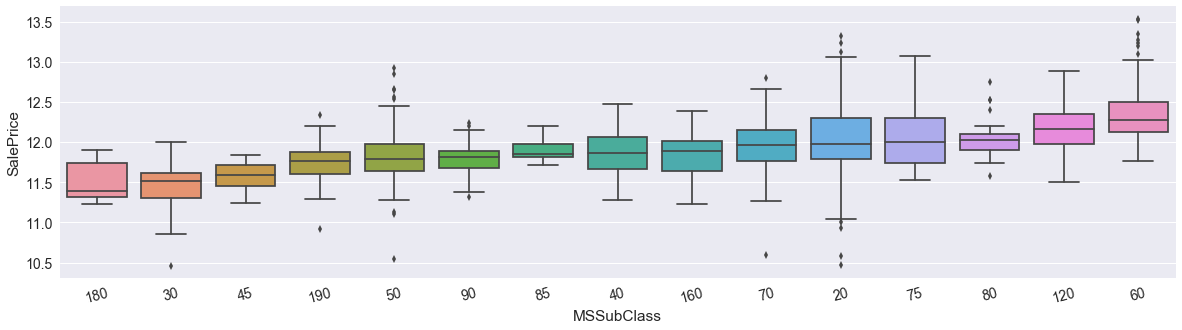

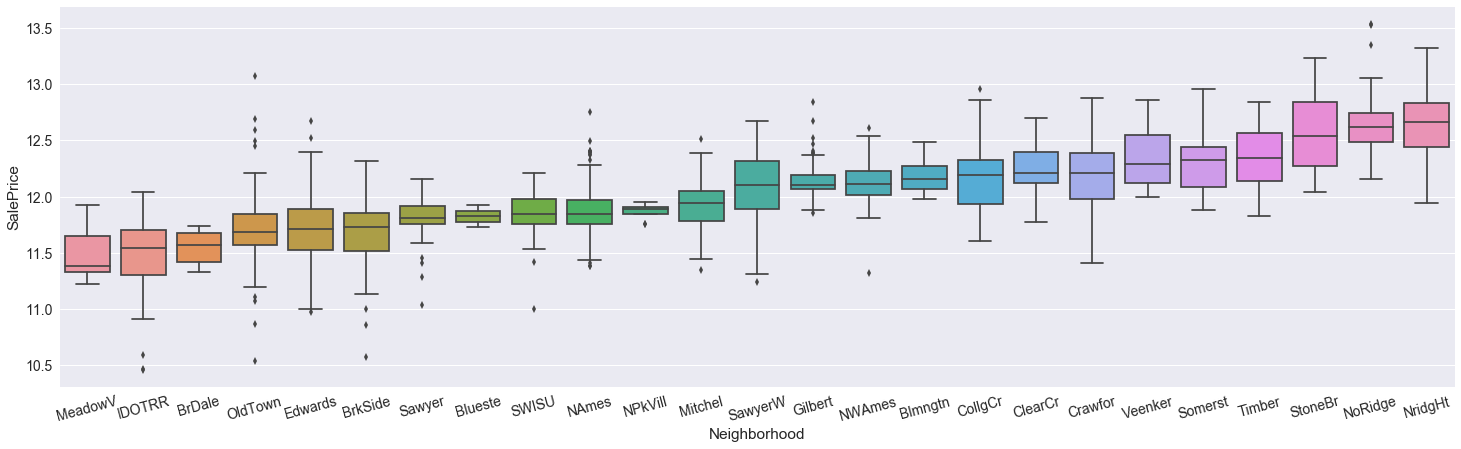

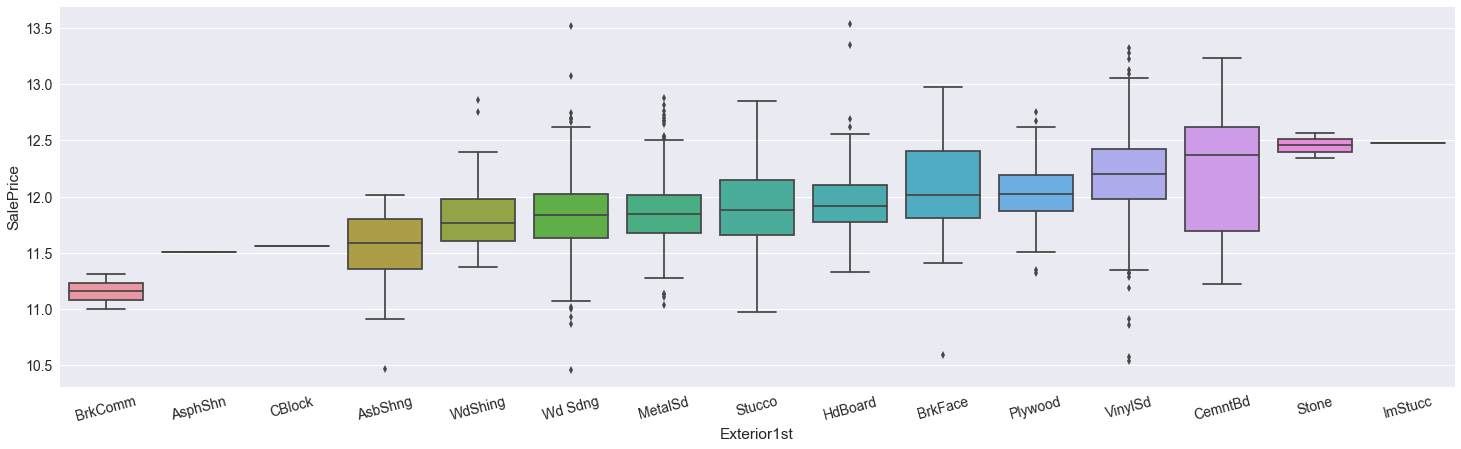

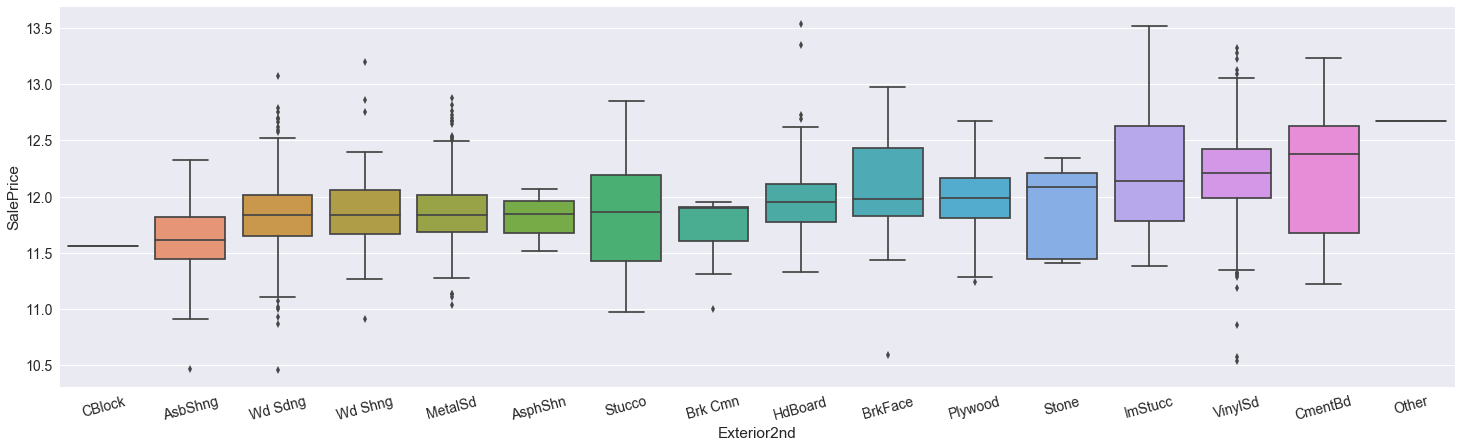

In [35]:
for i, categorical_var in enumerate(categorical_vars_more10):
    plt.figure()
    meds = pd.DataFrame(train.groupby(categorical_var).SalePrice.median())
    ordering = meds.sort_values(by = 'SalePrice').index
    sns.set(rc={'figure.figsize':(25,7)})
    sns.set(font_scale = 1.4)
    sns.boxplot(x = categorical_var, y = y, data = train, order = ordering)
    xt = plt.xticks(rotation=15)
    plt.show()

From the boxplots above, we can see that for the following variables there is a significant difference in SalePrice for the categories:  
__Alley, ExterQual, CentralAir, MsSubClass, Neigborhood__.

#### ▸ One-hot ecnoding

Now, we will factorize variables that have not-ordered values.  

In [36]:
categorical_no_order = ['LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 
 'Street', 'Alley','LotShape','LandContour','MSSubClass', 'MSZoning',
 'BsmtFinType1', 'BsmtFinType2','GarageFinish','Utilities',
 'BldgType','HouseStyle','RoofStyle', 'RoofMatl','Exterior1st', 'Electrical',
 'Exterior2nd', 'MasVnrType','Foundation', 'Functional','Fence',
 'GarageType', 'Heating', 'PavedDrive', 'SaleType','SaleCondition', 'MiscFeature']

In [37]:
data.reset_index(inplace=True)

In [38]:
dummies = pd.get_dummies(data[categorical_no_order])
data = data.drop(categorical_no_order, 1)
data = pd.concat([data,dummies], 1)

Further, we are recoding categorical variables that are ordinal.  
That is, we will treat these variables as numeric in what follows.  

One might criticize this approach for recoding, but our argument is that we keep the dimension of our dataset relatively low in such a way. One-hot encoding blows the dimensionality of data (number of variables increases dramatically), which is always hard to deal with.

In [39]:
data['ExterCond'] = data['ExterCond'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1 })
data['ExterQual'] = data['ExterQual'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1 })
data['BsmtQual'] = data['BsmtQual'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1, 'None':0 })
data['BsmtCond'] = data['BsmtCond'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1, 'None':0})
data['BsmtExposure'] = data['BsmtExposure'].replace({'Gd': 4,'Av': 3,'Mn': 2,'No':1,'None':0})
data['LandSlope'] = data['LandSlope'].replace({'Gtl':1, 'Mod':2, 'Sev':3})
data['HeatingQC'] = data['HeatingQC'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1 })
data['CentralAir'] = data['CentralAir'].replace({'N':0, 'Y':1})
data['KitchenQual'] = data['KitchenQual'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1 })
data['FireplaceQu'] = data['FireplaceQu'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1 ,'None':0})
data['GarageQual'] = data['GarageQual'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1, 'None':0 })
data['GarageCond'] = data['GarageCond'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1, 'None':0 })
data['PoolQC'] = data['PoolQC'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1, 'None':0 })

#### ▸ Deleting outliers

The author of the dataset, Dean De Cock points out the presence of the outliers in the dataset: 

"There are five observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these points). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these five unusual observations) before assigning it to students."

_Source:_ https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

To be on the safe side, we remove only two suspicious data points under Id's __1299__ and __524__.

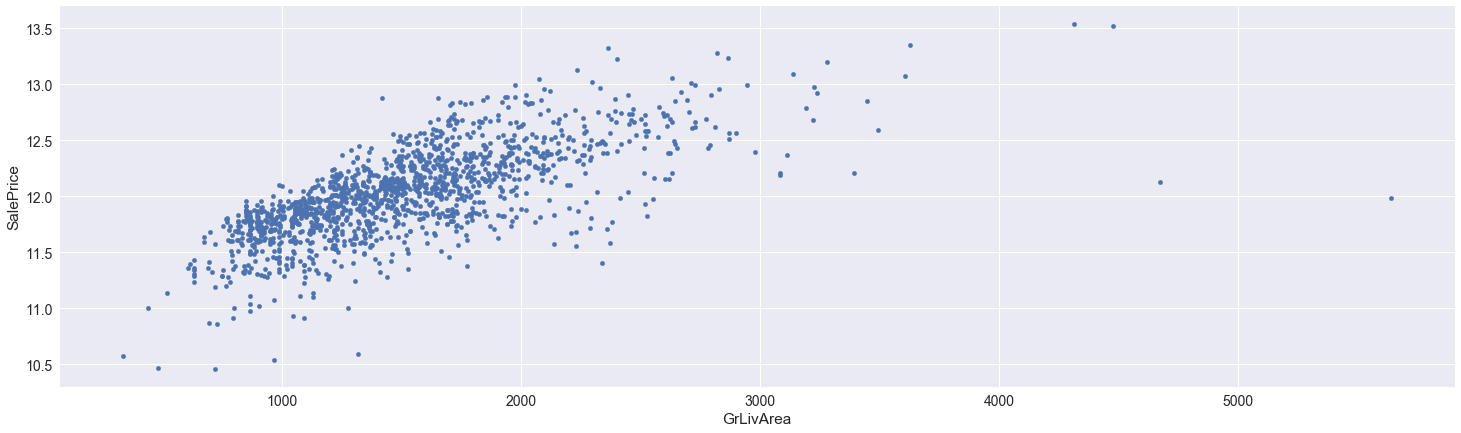

In [40]:
var = 'GrLivArea'
train.plot.scatter(x=var, y='SalePrice');

In [41]:
data[data.Id.isin(train_ind)].sort_values(by = 'GrLivArea', ascending = False)[:2]
data = data.drop(data[data['Id'] == 1299].index)
data = data.drop(data[data['Id'] == 524].index)
y = y.drop(y.index[[524,1299]])

<a id='feature_eng'></a>
### 2. Feature Engineering

Now, when have taken a close look at our feature, we get the flavour of our data and are ready to do some creative feature engineering.  

First, recalling the result of correlation analysis, in order to avoid multicollinearity, we aggregate and drop redundant variables.

#### ▸  Aggregating area-related variables

In [42]:
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
data = data.drop('TotalBsmtSF', 1)
data = data.drop('1stFlrSF', 1)
data = data.drop('2ndFlrSF',1)
data = data.drop('GarageArea',1)
data = data.drop('TotRmsAbvGrd',1)

#### ▸ Adding ‘House Age’ and ‘Remodeled (Yes/No)’ variables

Let's convert time-related variable in some meaningful quantities as age.

In [43]:
data['Age'] = data['YrSold'] - data['YearRemodAdd']
data['Remodeled'] = 1*data['YearRemodAdd']!=data['YearBuilt']
data['GarageAge']= data['YrSold'] - data['GarageYrBlt']
data = data.drop('YearBuilt', 1)
data = data.drop('YearRemodAdd', 1)
data = data.drop('GarageYrBlt', 1)

#### ▸  Seasonality & Financial Crisis

We continue to exploit time-related variables and add some seasonality features and crisis presence variable.

In [44]:
data['Summer'] = 1*data.MoSold.isin([6,7,8])
data['Winter'] = 1*data.MoSold.isin([12,1,2])
data['Autumn'] = 1*data.MoSold.isin([9,10,11])
data['Spring'] = 1*data.MoSold.isin([3,4,5])
data['Crisis'] = 1*data.YrSold.isin([2008])

In [45]:
data = data.drop('MoSold', 1)

#### ▸  HasPool variable & Removing Pool Quality variable

In [46]:
data['HasPool'] = 1*data['PoolArea']>0
data = data.drop('PoolQC', 1)

#### ▸ Total number of Bathrooms

In [47]:
data['NumBath'] = data['FullBath'] + 0.5*data['HalfBath'] + data['BsmtFullBath'] + 0.5*data['BsmtHalfBath']
data = data.drop(['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'], axis = 1)

Finally, we are ready to scale all the variables and get the preprocessed and tranformed train and test datasets.

In [48]:
numeric_vars = data.select_dtypes(exclude=['object']).columns.values
numeric_vars = np.delete(numeric_vars, np.where(numeric_vars=='Id'))

In [49]:
from sklearn import preprocessing
scaler = preprocessing.RobustScaler()
data[numeric_vars] = scaler.fit_transform(data[numeric_vars])

In [50]:
n = train.shape[0]
Y_train = y
X_train = data[data.Id.isin(train_ind)]
X_train = X_train.drop(['index','Id'], axis = 1)
X_test = data[data.Id.isin(test_ind)]
X_test = X_test.drop(['index','Id'], axis = 1)

In [51]:
X_train.head()

,LotFrontage,LotArea,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,...,Age,Remodeled,GarageAge,Summer,Winter,Autumn,Spring,Crisis,HasPool,NumBath
0,-0.257516,-0.257308,0.0,0.5,0.0,1.035949,1.0,0.0,0.0,0.0,...,-0.256410,0.0,-0.002234,0.0,1.0,0.0,0.0,1.0,0.0,1.500000
1,0.464671,0.035675,0.0,0.0,3.0,0.000000,0.0,0.0,0.0,0.0,...,0.410256,0.0,-0.491885,0.0,0.0,0.0,1.0,0.0,0.0,0.346574
2,-0.100761,0.399864,0.0,0.5,0.0,0.998801,1.0,0.0,0.0,0.0,...,-0.230769,1.0,-0.001739,0.0,0.0,1.0,0.0,1.0,0.0,1.500000
3,-0.535329,0.023685,0.0,0.5,0.0,0.000000,0.0,0.0,-1.0,1.0,...,0.538462,1.0,-0.993762,0.0,1.0,0.0,0.0,0.0,0.0,0.000000
4,0.634651,0.944281,0.0,1.0,0.0,1.149204,1.0,0.0,0.0,0.0,...,-0.179487,0.0,-0.001491,0.0,1.0,0.0,0.0,1.0,0.0,1.500000


In [52]:
X_train.shape

(1458, 267)

<a id='models'></a>
### 3. Models

We are going to use currently best performing models (in Kaggle competitions and in the worldwide machine learning practice). Namely:
1. 3 regularizaed linear models:
    - lasso
    - ridge
    - elastic net
2. 2 boosting regression models:
    - gboost
    - xgboost
3. neural networks

We will use sklearn, xgboost and Keras packages to implement these models.

For every model, in order to tune its parameters, we used cross-validation and for the optimal parameter value, we trained it on the whole training dataset.

In [53]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, Lasso
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

/Users/Maxim/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


First, we define RMSE function to compute loss for cross validation.

In [54]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, Y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)
rmse_cv = np.vectorize(rmse_cv)

### 3.1 Penalized Linear Regressions
#### ▸  LASSO

First, recall theoretical representation of LASSO estimator:
$$\hat{\beta}^L(\alpha)=argmin_{\beta}{\frac{1}{2n}\sum_{i=1}^{n}({Y_i-X_{i,\cdot}\beta})^2+\alpha \|\beta\|_1}$$
where $\lambda >0$.

The central issue is to find the optimal regularization parameter.  
To do this, we create a grid of possible parameter values from 0.0001 to 0.001. We explore the RMSE values of the LASSO model for each value of the parameter using 5-fold cross-validaton.  

In [55]:
alphas_lasso = np.linspace(0.0001, 0.001, num=100)

In [56]:
cv_lasso = [rmse_cv(Lasso(alpha = alpha)).mean() 
            for alpha in alphas_lasso]

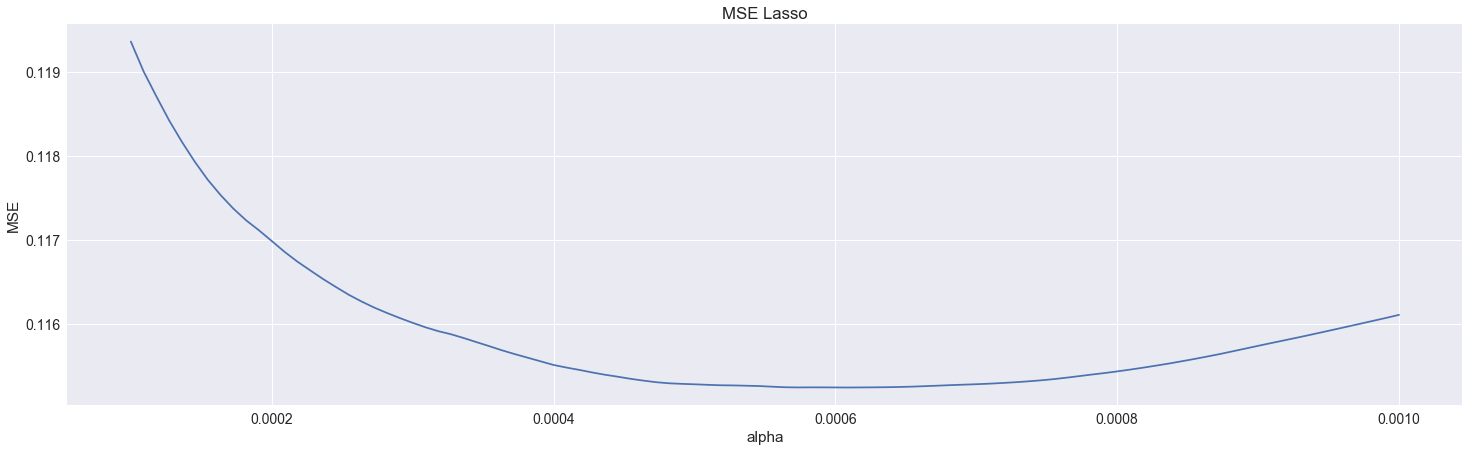

In [57]:
plt.plot(alphas_lasso, cv_lasso)
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('MSE Lasso')
plt.show()

We see that RMSE as a function of parameter value is convex, so we can easily find the optimal $alpha$.

In [58]:
opt_alpha = alphas_lasso[np.argmin(cv_lasso)]
print("The optimal lambda for LASSO: "+ str(opt_alpha))

The optimal lambda for LASSO: 0.0006090909090909092


In [59]:
lasso_model = Lasso(alpha=opt_alpha).fit(X_train,Y_train)
print("RMSE for optimal alpha = " + str(rmse_cv(lasso_model).mean()))

RMSE for optimal alpha = 0.11524280921105545


As we know, LASSO is suitable for variable selection. Hence, for our optimal parameter, we will select only those variables that didn't shrink.

In [60]:
coef = pd.Series(lasso_model.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 92 variables and eliminated the other 175 variables


Let's look at the most important (in absolute value) coefficients.

In [61]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

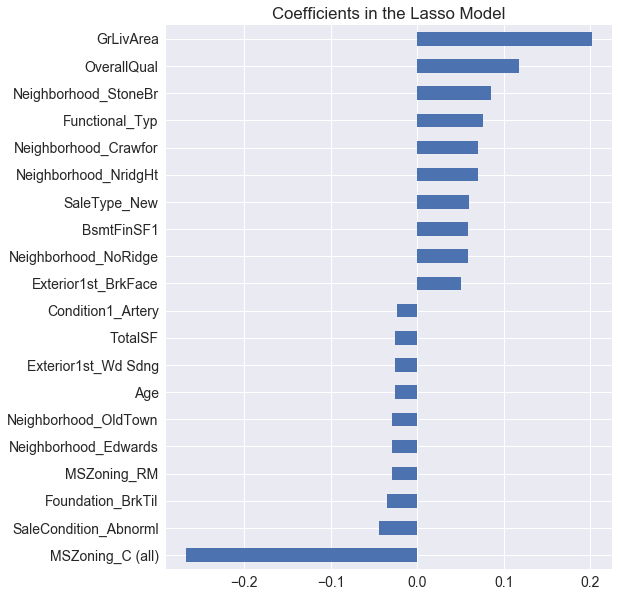

In [62]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

Finally, we draw a so-called LASSO path to see the importance of different variables as parameter $alpha$ grows.

In [63]:
def lasso_path(X,Y, lambdas, fit_int):
    betas_L = []
    for lambd in lambdas:
        model_L = Lasso(alpha=lambd, fit_intercept = fit_int)
        model_L.fit(X, Y)
        betas_L.append(model_L.coef_)

    plt.plot(np.log10(lambdas), betas_L)
    plt.xlabel('Log(lambda)')
    plt.ylabel('coefficients')
    plt.title('Lasso Path')
    plt.show()
    pass

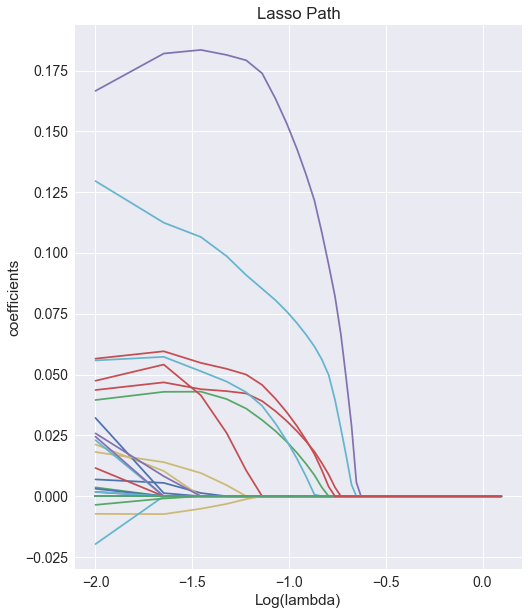

In [64]:
alphas_lasso = np.linspace(0.01,1.25,100)
lasso_path(X_train,Y_train,alphas_lasso,True)

#### ▸ Ridge


$$\hat{\alpha}^R(\mu)=argmin_{\beta}{\frac{1}{2n}\sum_{i=1}^{n}({Y_i-X_{i,\cdot}\beta})^2+\frac{\alpha}{2} \|\beta\|^2_2}$$
where $\mu >0$.

As in the case of LASSO, it is also crucial to find optimal parameter value for Ridge regression. Let's do it in the same way as for LASSO.

In [65]:
alphas_ridge =  np.linspace(0.001, 50 , num=100)
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas_ridge]

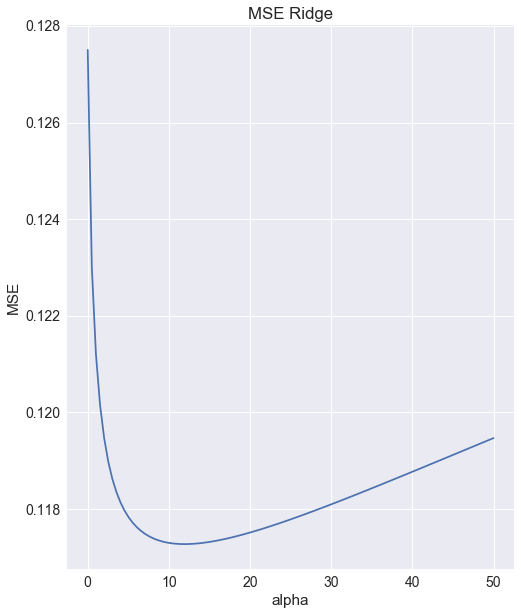

In [66]:
plt.plot(alphas_ridge,cv_ridge)
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('MSE Ridge')
plt.show()

Again, we see that RMSE as a function of Ridge parameter is convex, so we easily figure out the optimal parameter value.

In [67]:
opt_alpha_ridge = alphas_ridge[np.argmin(cv_ridge)]
print("The optimal lambda for Ridge: "+ str(opt_alpha_ridge))

The optimal lambda for Ridge: 12.121969696969698


In [69]:
ridge_model = Ridge(alpha=opt_alpha_ridge).fit(X_train,Y_train)
print("RMSE for optimal alpha = " + str(rmse_cv(ridge_model).mean()))

RMSE for optimal alpha = 0.11727461916576502


Notice that the loss is larger for Ridge regression than for LASSO. We can attribute this to the ability of LASSO estimator to select significant features effectively dealing with sparsity.

In [ ]:
coef_ridge = pd.Series(ridge_model.coef_, index = X_train.columns)
imp_coef = pd.concat([coef_ridge.sort_values().head(10),
                     coef_ridge.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

In [70]:
def ridge_path(X,Y, lambdas, fit_int):
    betas_L = []
    for lambd in lambdas:
        model_L = Ridge(alpha=lambd, fit_intercept = fit_int)
        model_L.fit(X, Y)
        betas_L.append(model_L.coef_)

    plt.plot(np.log10(lambdas), betas_L)
    plt.xlabel('Log(lambda)')
    plt.ylabel('coefficients')
    plt.title('Ridge Path')
    plt.show()
    pass

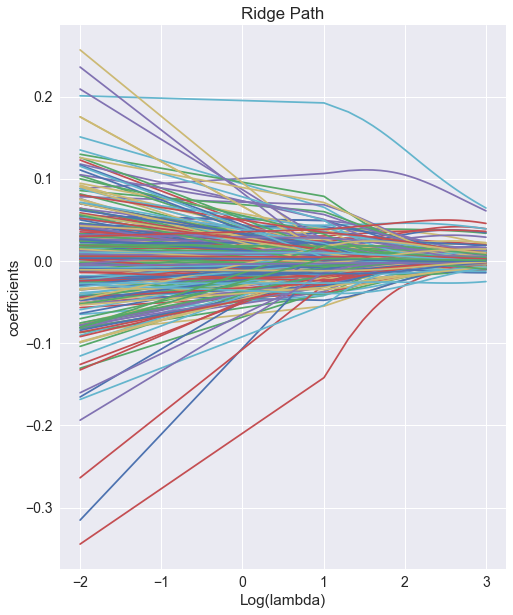

In [73]:
alphas_ridge = np.linspace(0.01,1000,100)
ridge_path(X_train,Y_train,alphas_ridge,True)

We know that Ridge regression doesn't make variable selection, so we just looked at the most important variables. 

#### ▸ Elastic net

$$\hat{\beta}^{EN}(\lambda,\alpha)=argmin_{\beta}{\frac{1}{2n}\sum_{i=1}^{n}({Y_i-X_{i,\cdot}\beta})^2+\lambda(\alpha \|\beta\|_1+\frac{1-\alpha}{2} \|\beta\|^2_2)}$$
where $\lambda >0$ and $\alpha \in [0,1]$.

For elastic net the search of optimal parameters is done on the 2-dimensional grid.  
As this search is computationally expensive, we take large steps upon one dimension. We also envision that the result will be closer to LASSO since it performes better thatn Ridge in terms of RMSE.

In [74]:
def rmse_cv_mean(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, Y_train, scoring="neg_mean_squared_error", cv = 2))
    return(rmse.mean())
rmse_cv_mean = np.vectorize(rmse_cv_mean)

In [75]:
alphas_enet =  np.linspace(0.0001, 20, num = 100)
lambdas = np.linspace(0, 1 , num = 10)

In [76]:
models = [ElasticNet(alpha = a , l1_ratio = l) for a in alphas_enet for l in lambdas] 

In [77]:
enet_cv = rmse_cv_mean(models)
opt_EN = np.argwhere(enet_cv == np.min(enet_cv))
opt_model = models[opt_EN[0][0]]

In [78]:
print("The optimal lambda for Elastic Net: "+ str(opt_model.alpha))
print("The optimal alpha for Elastic Net: "+ str(opt_model.l1_ratio))
print("Minimal RMSE = " + str(rmse_cv(opt_model).mean()))

The optimal lambda for Elastic Net: 0.0001
The optimal alpha for Elastic Net: 1.0
Minimal RMSE = 0.11935771433702717


Note that the result obtained by elastic net is very close to that obtained by LASSO as we expected.

In [79]:
opt_model.fit(X_train, Y_train)

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=1.0,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

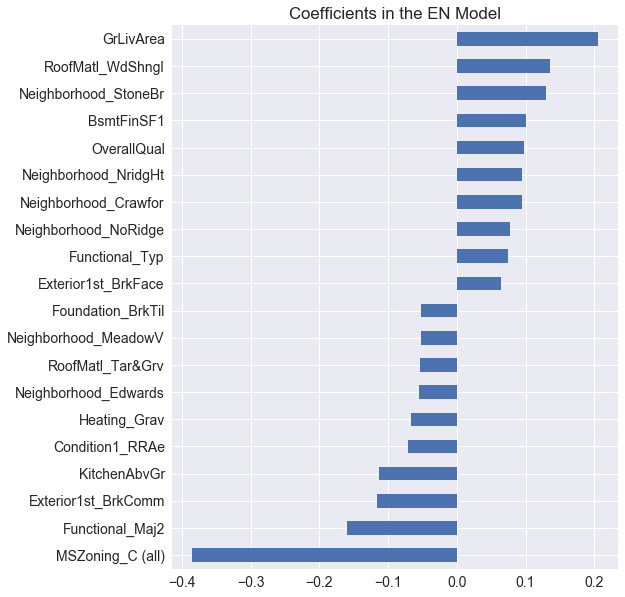

In [80]:
coef_EN = pd.Series(opt_model.coef_, index = X_train.columns)
imp_coef = pd.concat([coef_EN.sort_values().head(10),
                     coef_EN.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the EN Model")

We have built three regularized linear models.   
We can conclude that LASSO performed the best among them due to variable selection property. 
Notice that the most signficant features selected by all these linear estimators were almost the same. Let's point out some of them.  
__GrLivArea, OverallQuall__, and particular categories of __Neighborhood__ (that correspond to rich/prestigious districts) are positively related to the target. This result is completely in line with our findings during the exploratory analysis.  

Notice that __MSZoning_C__ is negatively related to the target (probably, not unfavourable zones). 

### 3.2 Gradient Boosting

Gradient boosting is one of the hottest models in machine learning today.  
It relies on the idea that the ensemble of weak prediction models might be very well performing. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

We will exploit two realizations of gradient boosting: GBoost and XGBoost.

Notice that both GBoost and XGBoost are __extremely__ sensitive to the parameters values.  
Moreover, the number of the parameters being tunes is >10. Hence, the number of possible combinations is larger than the dimensionality of the grid to the power of 10 (assuming the cardinality of grid is around 10, it will depass our computational resources).  

Therefore, we have taken a decision to perform so-called probabilistic parameter tuning (we pick te values of parameters not from the deterministic grid but randomly from the given domain) and in order to increase computational capacities, we performed these computation on the Microsoft Azure cloud.
Here, we will use the resulting optimal parameters values for both models.

#### ▸ GBoost

In [81]:
GBoost = GradientBoostingRegressor( min_impurity_decrease=0.0, min_impurity_split=None, max_leaf_nodes=None, n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt',min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =5)

In [83]:
print("RMSE for optimal parameters = " + str(rmse_cv(GBoost).mean()))

RMSE for optimal parameters = 0.11844509700196201


In [84]:
GBoost.fit(X_train,Y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=4,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             presort='auto', random_state=5, subsample=1.0, verbose=0,
             warm_start=False)

#### ▸ XGBoost

In [85]:
model_xgb = xgb.XGBRegressor(scale_pos_weight=1, seed=0, objective='reg:linear', missing=None, max_delta_step=0, colsample_bylevel=1, base_score=0.5, n_estimators=2200,learning_rate=0.05,max_depth=3, subsample=0.5213, silent=1,nthread = -1,reg_lambda=0.8571,reg_alpha=0.4640, min_child_weight=1.7817,  colsample_bytree=0.4603, gamma=0.0468) 
model_xgb.fit(X_train,Y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.4603,
       gamma=0.0468, learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1.7817, missing=None, n_estimators=2200,
       nthread=-1, objective='reg:linear', reg_alpha=0.464,
       reg_lambda=0.8571, scale_pos_weight=1, seed=0, silent=1,
       subsample=0.5213)

In [86]:
print("RMSE for optimal parameters = " + str(rmse_cv(model_xgb).mean()))

RMSE for optimal parameters = 0.11749945908609923


As we see, boosting regression models performed worse than linear regression models. However, the practice shows that boosting models are more robust and less prone to overfitting. We will therefore use them in our final ensemble of models.

#### ▸ Neural Networks

Neural networks are normally more suitable for data which doesn't exhibit linearity (which is not the case) and very prone to overfit.  

But inspired by your lecture, we decided to try to build a simple neural network just for fun :)

In [87]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [88]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 42)

In [89]:
from keras import backend as K
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [90]:
model = Sequential()
model.add(Dense(1, input_dim = X_train.shape[1], W_regularizer=l1(0.001)))
model.compile(optimizer = "adam", loss = rmse, 
              metrics =["accuracy"])

In [91]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 268       
Total params: 268
Trainable params: 268
Non-trainable params: 0
_________________________________________________________________


In [92]:
# Fit the model
hist = model.fit(X_tr, y_tr, validation_data = (X_val, y_val), epochs=50, batch_size=20,  verbose=2)

Train on 1093 samples, validate on 365 samples
Epoch 1/50
 - 0s - loss: 11.3350 - acc: 0.0000e+00 - val_loss: 10.6499 - val_acc: 0.0000e+00
Epoch 2/50
 - 0s - loss: 10.0392 - acc: 0.0000e+00 - val_loss: 9.3607 - val_acc: 0.0000e+00
Epoch 3/50
 - 0s - loss: 8.7537 - acc: 0.0000e+00 - val_loss: 8.0860 - val_acc: 0.0000e+00
Epoch 4/50
 - 0s - loss: 7.4707 - acc: 0.0000e+00 - val_loss: 6.8125 - val_acc: 0.0000e+00
Epoch 5/50
 - 0s - loss: 6.1932 - acc: 0.0000e+00 - val_loss: 5.5421 - val_acc: 0.0000e+00
Epoch 6/50
 - 0s - loss: 4.9815 - acc: 0.0000e+00 - val_loss: 4.4218 - val_acc: 0.0000e+00
Epoch 7/50
 - 0s - loss: 3.9918 - acc: 0.0000e+00 - val_loss: 3.5388 - val_acc: 0.0000e+00
Epoch 8/50
 - 0s - loss: 3.2457 - acc: 0.0000e+00 - val_loss: 2.9143 - val_acc: 0.0000e+00
Epoch 9/50
 - 0s - loss: 2.7297 - acc: 0.0000e+00 - val_loss: 2.4792 - val_acc: 0.0000e+00
Epoch 10/50
 - 0s - loss: 2.3674 - acc: 0.0000e+00 - val_loss: 2.2148 - val_acc: 0.0000e+00
Epoch 11/50
 - 0s - loss: 2.1490 - acc:

In [93]:
from sklearn.metrics import mean_squared_error
(mean_squared_error(Y_train, model.predict(X_train)[:,0]))**0.5

0.7628564694420332

We see that RMSE on the train set is very low but this is due to high overfit. We tried to evaluate the model on test data on Kaggle platform and had veeery poor results (around 0.266).  

<a id='ensemble'></a>
### Final ensemble

Empirically, we have established that the best performing ensemble of the models we built includes __LASSO, XGBoost__ and __GBoost__.
The weights of the models were also established empirically.

In [94]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(lasso_model.predict(X_test))
gboost_preds = np.expm1(GBoost.predict(X_test))

In [95]:
preds = 0.4*lasso_preds + 0.3*xgb_preds + 0.3*gboost_preds

Let us evaluate our ensemble on the test set and load it to the Kaggle platform.

In [96]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("maximka15.csv", index = False)

Wooow! We are in 
### __top 13%!__ ###
https://www.kaggle.com/maxberezov9  (please check)

This is a great result for us and it motivates us to keep improving.

## Conclusion

This project was a good opportunity to implement the full machine learning stack from data preprocessing, data exploration, through feature engineering to model construction, parameters tuning and final evaluation.

We learned to use basic python machine learning packages, to visualize the results and to present them.